## Dependencies

In [ ]:
pip install geopandas splot pysal watermark -q

     |████████████████████████████████| 1.0 MB 12.8 MB/s 
     |████████████████████████████████| 6.3 MB 80.1 MB/s 
     |████████████████████████████████| 16.7 MB 50.2 MB/s 
     |████████████████████████████████| 60 kB 7.4 MB/s 
     |████████████████████████████████| 116 kB 61.3 MB/s 
     |████████████████████████████████| 2.4 MB 60.0 MB/s 
     |████████████████████████████████| 209 kB 85.3 MB/s 
     |████████████████████████████████| 243 kB 64.9 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/s 
     |████████████████████████████████| 41 kB 617 kB/s 
     |████████████████████████████████| 5.7 MB 48.7 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 147 kB 75.0 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 179 kB 72.1 MB/s 
     |████████████████████████████████| 2.1 MB 42.2 MB/s 
     |████████████████████████████████| 78 kB 7.2 MB/s 
     |███████████████████

In [ ]:
import pandas as pd
import seaborn                   #for plotting graphs
from scipy.spatial.distance import cdist, pdist
import plotly.graph_objects as go #for plotting graphs
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from splot import esda as esdaplot
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights    # Spatial weights



In [ ]:
%reload_ext watermark
%watermark -iv -a 'Max Magid' -u -d -v

Author: Max Magid

Last updated: 2022-08-20

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.9.0

statsmodels: 0.12.2
google     : 2.0.3
libpysal   : 4.6.2
matplotlib : 3.2.2
geopandas  : 0.10.2
sklearn    : 1.0.2
plotly     : 5.5.0
shapely    : 1.8.4
esda       : 2.4.3
splot      : 1.1.5.post1
numpy      : 1.21.6
seaborn    : 0.11.2
pandas     : 1.3.5



## Import Datasets

In [ ]:
acs19=pd.read_csv('processed data/acs_19_filled.csv').iloc[:,1:]

In [ ]:
bband19=pd.read_csv('processed data/bband_2019.csv').iloc[:,1:]

In [ ]:
nanda_14_18=pd.read_csv('raw data/nanda_broadband_tract_2014-2018_01P.csv')

In [ ]:
msoft=pd.read_csv('raw data/microsoft_broadband_usage_county.csv', header=18)

In [ ]:
ibn=pd.read_csv('raw data/IBNTracts.csv')

In [ ]:
county_name=pd.read_csv('raw data/county_fips.csv')

## Preparing Broadband Indicators

In [ ]:
bband19['internet_percent']=bband19.has_internet/bband19.households*100

In [ ]:
bband19['broadband_percent']=bband19.has_broadband/bband19.households*100

In [ ]:
bband19.head(2)

,GEOID,households,has_internet,has_broadband,internet_percent,broadband_percent
0,14000US55001950100,1442.0,1199.0,1190.0,83.148405,82.524272
1,14000US55001950201,612.0,434.0,428.0,70.915033,69.934641


In [ ]:
bband19['key'] = bband19['GEOID'].str.slice(start=7).astype(int)

In [ ]:
broadband19=bband19[
    ['key','internet_percent','broadband_percent']
    ].merge(
        ibn,
        left_on='key',
        right_on='Geographic Identifier - FIPS Code'
        )

In [ ]:
broadband19.columns

Index(['key', 'internet_percent', 'broadband_percent',
       'Geographic Identifier - FIPS Code', 'Name', 'State', 'County',
       'Total households', 'Total households - Margin of Error',
       'Percent of Households that Have No Computer, Smartphone, or Tablet',
       'Percent of Households that Have No Computer, Smartphone, or Tablet - Margin of Error',
       'Percent of Households with No Internet Access',
       'Percent of Households with No Internet Access - Margin of Error',
       'Percent of Population whose income in the past 12 months is below poverty level',
       'Percent of Population whose income in the past 12 months is below poverty level - Margin of Error',
       'Form 477 All Terrestrial Broadband: Max Advertised Consumer Download Speed (Mbps)',
       'Form 477 All Terrestrial Broadband: Max Advertised Consumer Upload Speed (Mbps)',
       'Ookla Median Download Speed (Mbps)',
       'Ookla Median Upload Speed (Mbps)', 'Population 2019 (FCC Estimate)'],
    

In [ ]:
ind19=broadband19[['key','internet_percent','broadband_percent',
             'Form 477 All Terrestrial Broadband: Max Advertised Consumer Download Speed (Mbps)',
             'Form 477 All Terrestrial Broadband: Max Advertised Consumer Upload Speed (Mbps)',
             'Ookla Median Download Speed (Mbps)','Ookla Median Upload Speed (Mbps)']]

In [ ]:
ind19=ind19.rename(columns={'Form 477 All Terrestrial Broadband: Max Advertised Consumer Download Speed (Mbps)':'fcc_down',
                      'Form 477 All Terrestrial Broadband: Max Advertised Consumer Upload Speed (Mbps)':'fcc_up',
                      'Ookla Median Download Speed (Mbps)':'ookla_down',
                      'Ookla Median Upload Speed (Mbps)':'ookla_up'}).set_index('key')

In [ ]:
msoft.head()

,ST,COUNTY ID,COUNTY NAME,BROADBAND AVAILABILITY PER FCC,BROADBAND USAGE
0,AL,1001,Autauga County,0.8057,0.391
1,AL,1003,Baldwin County,0.8362,0.452
2,AL,1005,Barbour County,0.6891,0.324
3,AL,1007,Bibb County,0.3368,0.136
4,AL,1009,Blount County,0.758,0.199


## Find PCA Transform

In [ ]:
# standardize
ind19_norm=ind19.copy()
ind19_norm['internet_percent']=(ind19.internet_percent-ind19.internet_percent.mean())/ind19.internet_percent.std()
ind19_norm['broadband_percent']=(ind19.broadband_percent-ind19.broadband_percent.mean())/ind19.broadband_percent.std()
ind19_norm['fcc_down']=(ind19.fcc_down-ind19.fcc_down.mean())/ind19.fcc_down.std()
ind19_norm['fcc_up']=(ind19.fcc_up-ind19.fcc_up.mean())/ind19.fcc_up.std()
ind19_norm['ookla_down']=(ind19.ookla_down-ind19.ookla_down.mean())/ind19.ookla_down.std()
ind19_norm['ookla_up']=(ind19.ookla_up-ind19.ookla_up.mean())/ind19.ookla_up.std()

In [ ]:
ind19_norm=ind19_norm.dropna()

In [ ]:
scaler_data = preprocessing.StandardScaler().fit(ind19_norm)
dataS=scaler_data.transform(ind19_norm) 

In [ ]:
pca=PCA(1)
dataP=pca.fit_transform(dataS)
eigenvalues = pca.explained_variance_ratio_
eigenvalues[0]

0.4026008996986696

In [ ]:
ind19_norm['pca_score']=dataP
ind19_norm.head()

,internet_percent,broadband_percent,fcc_down,fcc_up,ookla_down,ookla_up,pca_score
key,,,,,,,
55001950100,0.149445,0.128408,-0.119771,0.108210,-0.131476,4.095587,1.534019
55001950201,-0.878037,-0.921689,-0.119771,0.108210,-1.601706,-1.043491,-1.998970
55001950202,-1.090566,-1.179299,-0.119771,0.108210,-1.458891,-0.650502,-2.063095
55001950400,-0.665433,-0.762299,-0.168992,-0.563081,-0.916244,-0.447347,-1.493242
55001950501,-0.931017,-1.108058,-0.529945,-0.619970,-1.730402,-1.067093,-2.468403


In [ ]:
ind19.merge(ind19_norm[['pca_score']],left_index=True,right_index=True)

,internet_percent,broadband_percent,fcc_down,fcc_up,ookla_down,ookla_up,pca_score
key,,,,,,,
55001950100,83.148405,82.524272,1000.0,1000.0,81.649002,77.263,1.534019
55001950201,70.915033,69.934641,1000.0,1000.0,15.115000,1.273,-1.998970
55001950202,68.384615,66.846154,1000.0,1000.0,21.577999,7.084,-2.063095
55001950400,73.446328,71.845574,940.0,115.0,46.134998,10.088,-1.493242
55001950501,70.284238,67.700258,500.0,40.0,9.291000,0.924,-2.468403
...,...,...,...,...,...,...,...
54109002901,75.426829,75.426829,1000.0,50.0,42.972000,9.395,-1.282816
54109002902,69.683908,69.683908,1000.0,20.0,37.244999,9.104,-1.875487
54109003000,75.858586,75.858586,1000.0,115.0,27.903999,8.130,-1.393538


## Find Grouping by Broadband

In [ ]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
        
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()

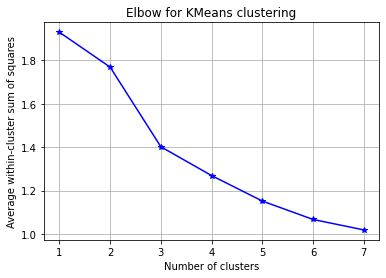

In [ ]:
elbow(ind19_norm.iloc[:,:6], range(1,8))

In [ ]:
rr=KMeans(n_clusters=3, n_init=10, random_state=0).fit(ind19_norm.iloc[:,:6])

rr.labels_ = rr.predict(ind19_norm.iloc[:,:6]) #get labels

In [ ]:
ind19_norm['cluster_id'] = rr.labels_
ind19_norm['cluster_id'] = ind19_norm['cluster_id'].astype(str)

In [ ]:
categ=ind19_norm.groupby(by=['cluster_id']).agg({'pca_score':'median'})

In [ ]:
categ.loc[categ['pca_score'].idxmax(), 'cluster_name'] = 'good_internet'
categ.loc[categ['pca_score'].idxmin(), 'cluster_name'] = 'poor_internet'
categ.loc[categ['pca_score']==categ['pca_score'].median(),'cluster_name'] = 'limited_internet'
categ

,pca_score,cluster_name
cluster_id,,
0,3.763233,good_internet
1,-1.307856,poor_internet
2,0.771860,limited_internet


In [ ]:
categ_mapper = categ['cluster_name'].to_dict()

In [ ]:
#cat_name=[]
#for i in range(len(ind19_norm)):
#  if ind19_norm.iloc[i].cluster_id==str(int(categ.loc[categ.pca_score==categ.pca_score.max()].cluster_id)):
#    cat_name.append('good_internet')
#  elif ind19_norm.iloc[i].cluster_id==str(int(categ.loc[categ.pca_score==categ.pca_score.median()].cluster_id)):
#    cat_name.append('limited_internet')
#  elif ind19_norm.iloc[i].cluster_id==str(int(categ.loc[categ.pca_score==categ.pca_score.min()].cluster_id)):
#    cat_name.append('poor_internet')

#ind19_norm['cluster_name']=cat_name

In [ ]:
ind19_norm['cluster_name'] = ind19_norm['cluster_id'].map(categ_mapper)

In [ ]:
ind19_norm

,internet_percent,broadband_percent,fcc_down,fcc_up,ookla_down,ookla_up,pca_score,cluster_id,cluster_name
key,,,,,,,,,
55001950100,0.149445,0.128408,-0.119771,0.108210,-0.131476,4.095587,1.534019,2,limited_internet
55001950201,-0.878037,-0.921689,-0.119771,0.108210,-1.601706,-1.043491,-1.998970,1,poor_internet
55001950202,-1.090566,-1.179299,-0.119771,0.108210,-1.458891,-0.650502,-2.063095,1,poor_internet
55001950400,-0.665433,-0.762299,-0.168992,-0.563081,-0.916244,-0.447347,-1.493242,1,poor_internet
55001950501,-0.931017,-1.108058,-0.529945,-0.619970,-1.730402,-1.067093,-2.468403,1,poor_internet
...,...,...,...,...,...,...,...,...,...
54109002901,-0.499090,-0.463587,-0.119771,-0.612385,-0.986138,-0.494213,-1.282816,1,poor_internet
54109002902,-0.981439,-0.942603,-0.119771,-0.635140,-1.112690,-0.513893,-1.875487,1,poor_internet
54109003000,-0.462827,-0.427575,-0.119771,-0.563081,-1.319102,-0.579763,-1.393538,1,poor_internet


## Connecting Scores to Demographics

In [ ]:
acs19.columns

Index(['Unnamed: 0.1', 'population', 'median_age', 'median_age_male',
       'median_age_female', 'percent_male', 'percent_female', 'white', 'black',
       'native', 'asian', 'pacific_islander', 'other', 'mixed',
       'white_nonhispanic', 'black_nonhispanic', 'native_nonhispanic',
       'asian_nonhispanic', 'pacific_islander_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic', 'hispanic',
       'percent_noncitizen', 'born_in_state', 'born_in_other_state',
       'foreign_born', 'spanish_no_english', 'no_english', 'work_from_home',
       'average_commute', 'under_18', 'over_18', 'highschool_or_less',
       'no_bachelor_degree', 'bachelor_degree_only', 'advanced_degree',
       'percent_poverty', 'percent_disabled', 'less_than_10k', '10k_15k',
       '15k_20k', '20k_25k', '25k_30k', '30k_35k', '35k_40k', '40k_45k',
       '45k_50k', '50k_60k', '60k_75k', '75k_100k', '100k_125k', '125k_150k',
       '150k_200k', 'more_than_200k', 'percentage_food_stamps',
       'percenta

In [ ]:
df19=acs19.merge(ind19_norm[['pca_score','cluster_name']],right_index=True,left_on='GEOID')

In [ ]:
df19['geometry'] = df19['geometry'].apply(wkt.loads)

In [ ]:
gdf19=gpd.GeoDataFrame(df19, geometry='geometry')

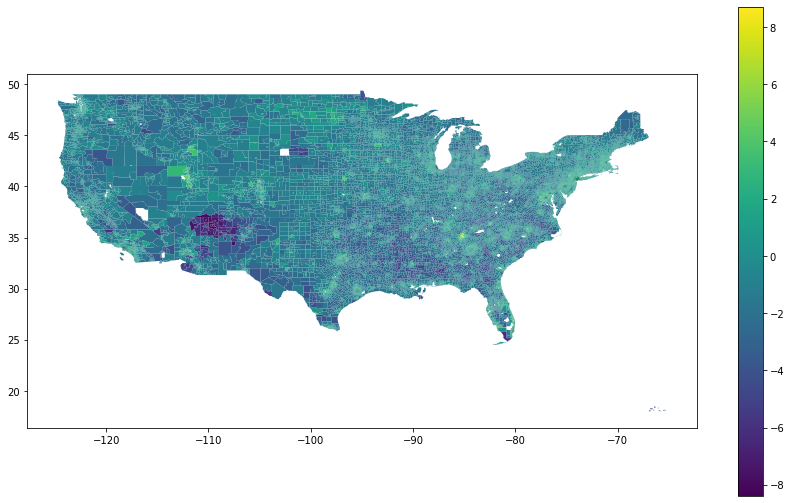

In [ ]:
gdf19.loc[(gdf19.INTPTLON<-50)&(gdf19.INTPTLON>-130)].plot(figsize = (15,9),
                                                           column='pca_score',
                                                           legend=True)

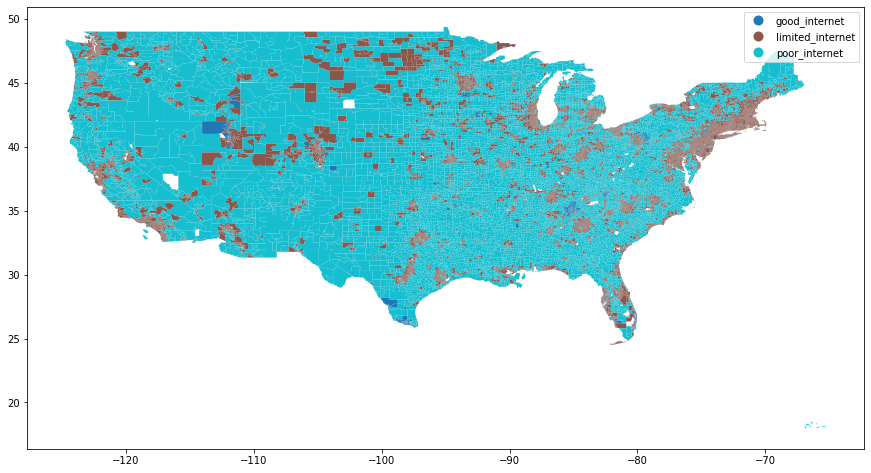

In [ ]:
gdf19.loc[(gdf19.INTPTLON<-50)&(gdf19.INTPTLON>-130)].plot(figsize = (15,9),
                                                           column='cluster_name',
                                                           legend=True)

# This shows us that the K-means was largely unhelpful

## Grouping by Density

In [ ]:
#df19['dense_log']=np.log((df19.density-df19.density.mean())/df19.density.std())
df19['dense_log']=np.log(df19['density'])

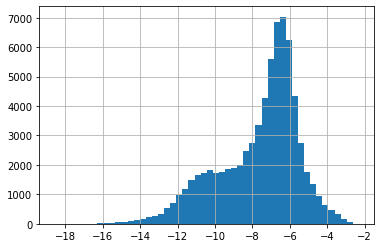

In [ ]:
df19['dense_log'].hist(bins=50)

This density histogram shows dual peaks. I estimate the dividing line at around log(density)=-9. I assume one curve is for metropolitan regions, while the other curve is for rural communities. I will further divide these regions in half to create four categories: urban, suburban, town, and rural.

In [ ]:
urban_mid=df19.loc[df19.dense_log>=-9].dense_log.median()
rural_mid=df19.loc[df19.dense_log<-9].dense_log.median()

In [ ]:
urban=df19.loc[df19.dense_log>=urban_mid]
suburban=df19.loc[(df19.dense_log>=-9)&(df19.dense_log<urban_mid)]
town=df19.loc[(df19.dense_log>=rural_mid)&(df19.dense_log<-9)]
rural=df19.loc[df19.dense_log<rural_mid]

In [ ]:
print(f'The average urban pca internet score is {round(urban.pca_score.mean(),4)} \
and the number of census tracts is {len(urban)}')

print(f'The average suburban pca internet score is {round(suburban.pca_score.mean(),4)} \
and the number of census tracts is {len(suburban)}')

print(f'The average town pca internet score is {round(town.pca_score.mean(),4)} \
and the number of census tracts is {len(town)}')

print(f'The average rural pca internet score is {round(rural.pca_score.mean(),4)} \
and the number of census tracts is {len(rural)}')

The average urban pca internet score is 0.3903 and the number of census tracts is 27245
The average suburban pca internet score is 0.3418 and the number of census tracts is 27245
The average town pca internet score is -0.4548 and the number of census tracts is 8857
The average rural pca internet score is -1.5257 and the number of census tracts is 8857


In [ ]:
tract_type=[]
for i in range(len(df19)):
  if df19.iloc[i]['dense_log']>=urban_mid:
    tract_type.append('urban')
  elif (df19.iloc[i]['dense_log']>=-9)&(df19.iloc[i]['dense_log']<urban_mid):
    tract_type.append('suburban')
  elif (df19.iloc[i]['dense_log']>=rural_mid)&(df19.iloc[i]['dense_log']<-9):
    tract_type.append('town')
  elif df19.iloc[i]['dense_log']<rural_mid:
    tract_type.append('rural')

In [ ]:
gdf19['tract_type']=tract_type

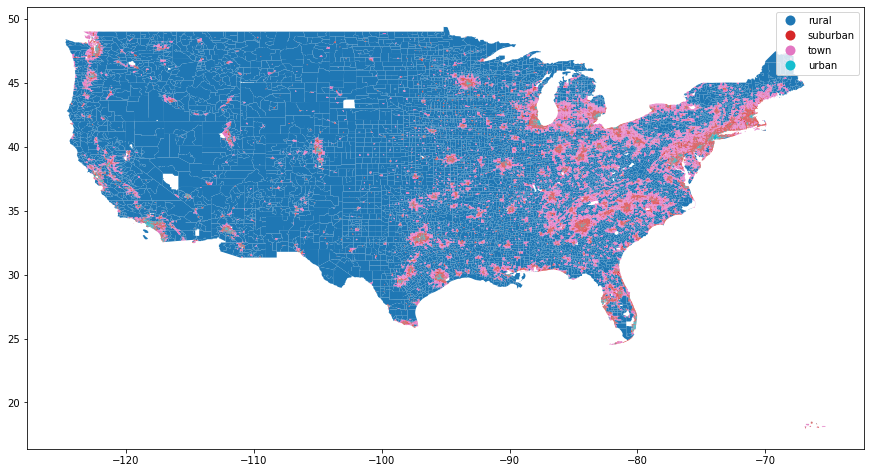

In [ ]:
gdf19.loc[(gdf19.INTPTLON<-50)&(gdf19.INTPTLON>-130)].plot(figsize = (15,9),
                                                           column='tract_type',
                                                           legend=True)

Looks like my classification is mostly correct, although a lot of the areas I classified as "towns" are exurbs and some less-dense cities might be classified entirely as suburbs. Still, the general classification seems to work

## Finding Internet Outliers by Density

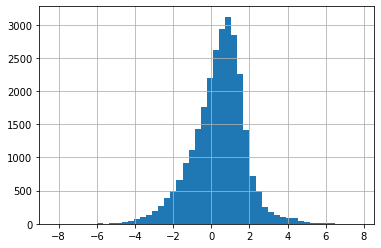

In [ ]:
urban['pca_score'].hist(bins=50)

(-10.0, 10.0)

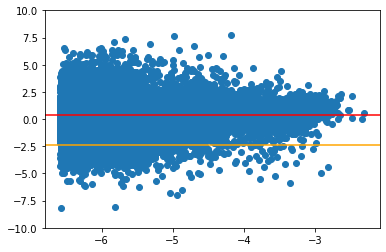

In [ ]:
df_mean=urban.pca_score.mean()
ustd2=-2*urban.pca_score.std()+df_mean
plt.scatter(x=urban.dense_log,y=urban.pca_score)
plt.axhline(y=df_mean, color='r', linestyle='-')
plt.axhline(y=ustd2, color='orange', linestyle='-')
plt.ylim([-10,10])

(-10.0, 10.0)

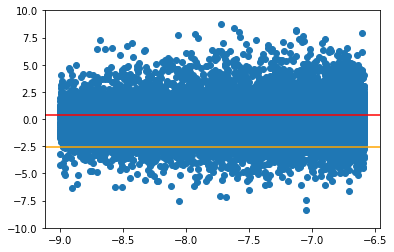

In [ ]:
df_mean=suburban.pca_score.mean()
sstd2=-2*suburban.pca_score.std()+df_mean
plt.scatter(x=suburban.dense_log,y=suburban.pca_score)
plt.axhline(y=df_mean, color='r', linestyle='-')
plt.axhline(y=sstd2, color='orange', linestyle='-')
plt.ylim([-10,10])

(-10.0, 10.0)

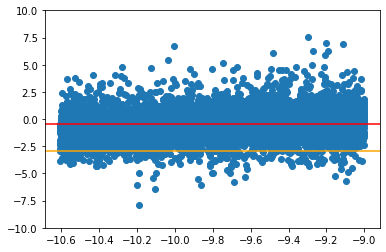

In [ ]:
df_mean=town.pca_score.mean()
tstd2=-2*town.pca_score.std()+df_mean
plt.scatter(x=town.dense_log,y=town.pca_score)
plt.axhline(y=df_mean, color='r', linestyle='-')
plt.axhline(y=tstd2, color='orange', linestyle='-')
plt.ylim([-10,10])

(-10.0, 10.0)

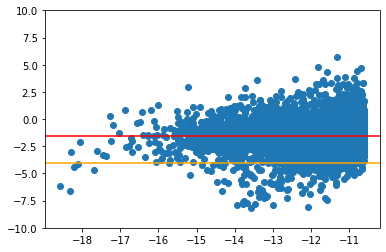

In [ ]:
df_mean=rural.pca_score.mean()
rstd2=-2*rural.pca_score.std()+df_mean
plt.scatter(x=rural.dense_log,y=rural.pca_score)
plt.axhline(y=df_mean, color='r', linestyle='-')
plt.axhline(y=rstd2, color='orange', linestyle='-')
plt.ylim([-10,10])

Calculate "outlierness" by grouping tracts into internet standard deviation groups

In [ ]:
urban_mean,urban_std=urban.pca_score.mean(),urban.pca_score.std()
suburban_mean,suburban_std=suburban.pca_score.mean(),suburban.pca_score.std()
town_mean,town_std=town.pca_score.mean(),town.pca_score.std()
rural_mean,rural_std=rural.pca_score.mean(),rural.pca_score.std()

In [ ]:
std_group=[]
for i in range(len(gdf19)):
  if gdf19.iloc[i].tract_type=='urban':
    out_grp=round((gdf19.iloc[i].pca_score-urban_mean)/urban_std,0)
    std_group.append(out_grp)
  elif gdf19.iloc[i].tract_type=='suburban':
    out_grp=round((gdf19.iloc[i].pca_score-suburban_mean)/suburban_std,0)
    std_group.append(out_grp)
  elif gdf19.iloc[i].tract_type=='town':
    out_grp=round((gdf19.iloc[i].pca_score-town_mean)/town_std,0)
    std_group.append(out_grp)
  elif gdf19.iloc[i].tract_type=='rural':
    out_grp=round((gdf19.iloc[i].pca_score-rural_mean)/rural_std,0)
    std_group.append(out_grp)

In [ ]:
gdf19['std_group']=std_group

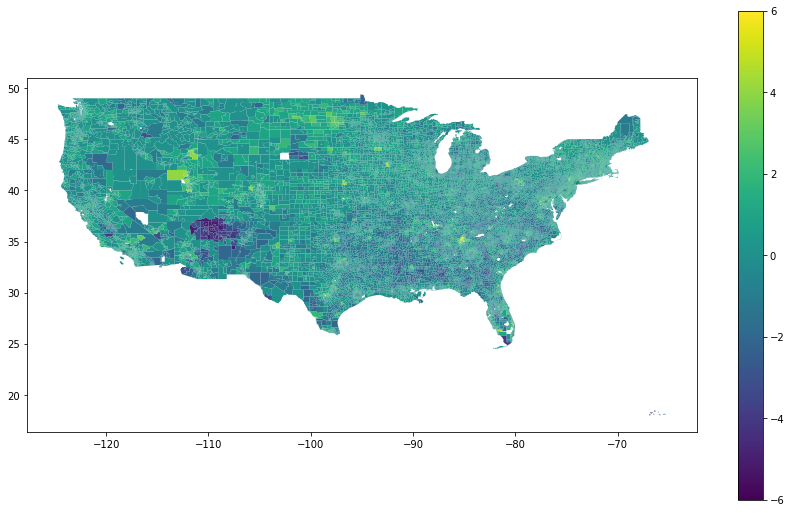

In [ ]:
gdf19.loc[(gdf19.INTPTLON<-50)&(gdf19.INTPTLON>-130)].plot(figsize = (15,9),
                                                           column='std_group',
                                                           legend=True)

In [ ]:
gdf19["cscore_calculator"]=gdf19.population*gdf19.std_group

county_score=gdf19.groupby(by=['STATEFP','COUNTYFP'],as_index=False).apply(lambda x: pd.Series(dict(
    urban=(x.tract_type == 'urban').sum(),
    suburban=(x.tract_type == 'suburban').sum(),
    town=(x.tract_type == 'town').sum(),
    rural=(x.tract_type=='rural').sum(),
    cscore=x.cscore_calculator.sum(),
    population=x.population.sum())))

county_score['score']=round(county_score.cscore/county_score.population,1)
county_score=county_score.sort_values(by=['score','urban','suburban','town','population'],ascending=[True,False,False,False,False])
county_score['fip']=county_score.COUNTYFP+1000*county_score.STATEFP
county_score=county_score.merge(county_name,left_on='fip',right_on='FIPS')

In [ ]:
# Bottom Ten Counties by Broadband/Internet Access
display=county_score.loc[county_score.State!='PR'][['Name','State','population','score']]
display.head(10)

,Name,State,population,score
0,Telfair,GA,16035.0,-3.7
1,Apache,AZ,71511.0,-3.5
4,McKinley,NM,72438.0,-3.0
5,Todd,SD,10195.0,-3.0
6,Issaquena,MS,1361.0,-3.0
7,Leflore,MS,29222.0,-2.8
8,East Carroll,LA,7096.0,-2.8
9,Yukon-Koyukuk,AK,5377.0,-2.8
11,West Carroll,LA,11041.0,-2.7
12,Tensas,LA,4561.0,-2.7


In [ ]:
# Bottom Ten Counties by Broadband/Internet Access with urban areas
urban_display=county_score.loc[(county_score.State!='PR')&(county_score.urban>0)][['Name','State','population','score']]
urban_display.head(10)

,Name,State,population,score
143,San Juan,NM,126515.0,-1.5
144,Prince Edward,VA,22905.0,-1.5
208,Zapata,TX,14304.0,-1.3
249,Petersburg City,VA,31362.0,-1.2
299,Roanoke City,VA,99229.0,-1.1
300,Caddo,LA,245831.0,-1.1
301,Mifflin,PA,46276.0,-1.1
302,Gray,TX,22410.0,-1.1
303,Deaf Smith,TX,18736.0,-1.1
343,Northumberland,PA,91761.0,-1.0


In [ ]:
# Bottom Ten Counties by Broadband/Internet Access with urban or suburban areas
metro_display=county_score.loc[(county_score.State!='PR')&((county_score.urban>0)|(county_score.suburban>0))][['Name','State','population','score']]
metro_display.head(10)

,Name,State,population,score
1,Apache,AZ,71511.0,-3.5
4,McKinley,NM,72438.0,-3.0
7,Leflore,MS,29222.0,-2.8
8,East Carroll,LA,7096.0,-2.8
14,Madison,LA,11306.0,-2.6
19,Copiah,MS,28501.0,-2.5
20,Richland,LA,20350.0,-2.5
23,Webster,LA,39242.0,-2.4
29,Jefferson,AR,67625.0,-2.3
34,St Francis,AR,25900.0,-2.2


## Finding Outliers by Race

In [ ]:
gdf19.iloc[0].white_nonhispanic

0.9701188455008488

In [ ]:
race_comp=gdf19.groupby(by=['std_group'],as_index=False).apply(lambda x: pd.Series(dict(
    white=(x.white_nonhispanic*x.population).sum(),
    black=(x.black_nonhispanic*x.population).sum(),
    hispanic=(x.hispanic*x.population).sum(),
    asian=(x.asian_nonhispanic*x.population).sum(),
    mixed=(x.mixed_nonhispanic*x.population).sum(),
    native=(x.native_nonhispanic*x.population).sum(),
    p_i=(x.pacific_islander_nonhispanic*x.population).sum(),
    other=(x.other_nonhispanic*x.population).sum(),
    urban=(x.tract_type == 'urban').sum(),
    suburban=(x.tract_type == 'suburban').sum(),
    town=(x.tract_type == 'town').sum(),
    rural=(x.tract_type=='rural').sum(),
    population=x.population.sum())))

race_comp.head(2)

,std_group,white,black,hispanic,asian,mixed,native,p_i,other,urban,suburban,town,rural,population
0,-6.0,3414.0,1671.0,412.0,429.0,187.0,16.0,0.0,6.0,2.0,1.0,1.0,0.0,6135.0
1,-5.0,52061.0,15370.0,10339.0,1363.0,1512.0,44352.0,55.0,45.0,10.0,9.0,3.0,15.0,125097.0


In [ ]:
low_outlier=race_comp.loc[race_comp.std_group<1][['white','black','hispanic','asian','mixed','native','p_i','other','population']]
hi_outlier=race_comp.loc[race_comp.std_group>1][['white','black','hispanic','asian','mixed','native','p_i','other','population']]

In [ ]:
l_o=pd.DataFrame(data=low_outlier.sum()/low_outlier.population.sum()).rename(columns={0:'l_o'}).iloc[:8]
h_o=pd.DataFrame(data=hi_outlier.sum()/hi_outlier.population.sum()).rename(columns={0:'h_o'}).iloc[:8]
not_o=pd.DataFrame(data=race_comp.sum()/race_comp.population.sum()).rename(columns={0:'not_o'}).iloc[1:9]

rc=l_o.merge(h_o,left_index=True,right_index=True).merge(not_o,left_index=True,right_index=True)
rc['l_o']=rc.l_o/rc.not_o
rc['h_o']=rc.h_o/rc.not_o
rc['not_o']=rc.not_o/rc.not_o

rc

,l_o,h_o,not_o
white,0.962795,1.072466,1.0
black,1.155533,0.743735,1.0
hispanic,1.087911,0.829506,1.0
asian,0.764377,1.350251,1.0
mixed,0.958729,1.064763,1.0
native,1.230016,0.566108,1.0
p_i,1.053734,1.073384,1.0
other,0.928534,1.161374,1.0


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=rc.l_o,theta=rc.l_o.index,fill='toself',name='low_outliers'))
fig.add_trace(go.Scatterpolar(r=rc.h_o,theta=rc.h_o.index,fill='toself',name='hi_outliers'))
fig.add_trace(go.Scatterpolar(r=rc.not_o,theta=rc.not_o.index,fill='toself',name='all'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 1.5])),showlegend=True)

fig.show()

Above is a chart that compares the average racial makeup of low internet outliers (blue), high internet outliers (red), to the overall racial makeup of the country (green).

Black, Hispanic, and Native people are overrepresented in areas with unusually poor internet access and underepresented in areas with unusually high internet access.

In [ ]:
W=(gdf19.white_nonhispanic*gdf19.population).sum()
B=(gdf19.black_nonhispanic*gdf19.population).sum()
H=(gdf19.hispanic*gdf19.population).sum()
A=(gdf19.asian_nonhispanic*gdf19.population).sum()
M=(gdf19.mixed_nonhispanic*gdf19.population).sum()
N=(gdf19.native_nonhispanic*gdf19.population).sum()
PI=(gdf19.pacific_islander_nonhispanic*gdf19.population).sum()
O=(gdf19.other_nonhispanic*gdf19.population).sum()

In [ ]:
average_group=(gdf19.std_group*gdf19.population).sum()/gdf19.population.sum()
W_group=((gdf19.white_nonhispanic*gdf19.std_group*gdf19.population).sum()/W)/average_group+9
B_group=((gdf19.black_nonhispanic*gdf19.std_group*gdf19.population).sum()/B)/average_group+9
H_group=((gdf19.std_group*gdf19.hispanic*gdf19.population).sum()/H)/average_group+9
A_group=((gdf19.std_group*gdf19.asian_nonhispanic*gdf19.population).sum()/A)/average_group+9
M_group=((gdf19.std_group*gdf19.mixed_nonhispanic*gdf19.population).sum()/M)/average_group+9
N_group=((gdf19.std_group*gdf19.native_nonhispanic*gdf19.population).sum()/N)/average_group+9
PI_group=((gdf19.std_group*gdf19.pacific_islander_nonhispanic*gdf19.population).sum()/PI)/average_group+9
O_group=((gdf19.std_group*gdf19.other_nonhispanic*gdf19.population).sum()/O)/average_group+9

In [ ]:
average_group=(gdf19.pca_score*gdf19.population).sum()/gdf19.population.sum()
W_group=((gdf19.white_nonhispanic*gdf19.pca_score*gdf19.population).sum()/W)/average_group+9
B_group=((gdf19.black_nonhispanic*gdf19.pca_score*gdf19.population).sum()/B)/average_group+9
H_group=((gdf19.pca_score*gdf19.hispanic*gdf19.population).sum()/H)/average_group+9
A_group=((gdf19.pca_score*gdf19.asian_nonhispanic*gdf19.population).sum()/A)/average_group+9
M_group=((gdf19.pca_score*gdf19.mixed_nonhispanic*gdf19.population).sum()/M)/average_group+9
N_group=((gdf19.pca_score*gdf19.native_nonhispanic*gdf19.population).sum()/N)/average_group+9
PI_group=((gdf19.pca_score*gdf19.pacific_islander_nonhispanic*gdf19.population).sum()/PI)/average_group+9
O_group=((gdf19.pca_score*gdf19.other_nonhispanic*gdf19.population).sum()/O)/average_group+9

In [ ]:
average_group=[W_group,B_group,H_group,A_group,M_group,N_group,PI_group,O_group]
rc['relative_average']=average_group


fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=rc.relative_average,theta=rc.relative_average.index,fill='toself',name='relative_average'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 15])),showlegend=False)

fig.show()

The chart above shows the average internet score of each ethnicity compared to the nations average (set to 10 in this example).

In [ ]:
N_ave_pop=N/gdf19.population.sum()
B_ave_pop=B/gdf19.population.sum()
H_ave_pop=H/gdf19.population.sum()

In [ ]:
gdf19.columns

Index(['population', 'median_age', 'median_age_male', 'median_age_female',
       'percent_male', 'percent_female', 'white', 'black', 'native', 'asian',
       'pacific_islander', 'other', 'mixed', 'white_nonhispanic',
       'black_nonhispanic', 'native_nonhispanic', 'asian_nonhispanic',
       'pacific_islander_nonhispanic', 'other_nonhispanic',
       'mixed_nonhispanic', 'hispanic', 'percent_noncitizen', 'born_in_state',
       'born_in_other_state', 'foreign_born', 'spanish_no_english',
       'no_english', 'work_from_home', 'average_commute', 'under_18',
       'over_18', 'highschool_or_less', 'no_bachelor_degree',
       'bachelor_degree_only', 'advanced_degree', 'percent_poverty',
       'percent_disabled', 'less_than_10k', '10k_15k', '15k_20k', '20k_25k',
       '25k_30k', '30k_35k', '35k_40k', '40k_45k', '45k_50k', '50k_60k',
       '60k_75k', '75k_100k', '100k_125k', '125k_150k', '150k_200k',
       'more_than_200k', 'percentage_food_stamps', 'percentage_employed',
       'p

In [ ]:
gdf19["cscore_calculator"]=gdf19.population*gdf19.std_group

county_score=gdf19.groupby(by=['STATEFP','COUNTYFP'],as_index=False).apply(lambda x: pd.Series(dict(
    urban=(x.tract_type == 'urban').sum(),
    suburban=(x.tract_type == 'suburban').sum(),
    native_population=(x.native_nonhispanic * x.population).sum(),
    black_population=(x.black_nonhispanic * x.population).sum(),
    hispanic_population=(x.hispanic * x.population).sum(),
    cscore=x.cscore_calculator.sum(),
    population=x.population.sum())))

county_score['score']=round(county_score.cscore/county_score.population,1)
county_score=county_score.sort_values(by=['score','population','native_population','black_population','hispanic_population'],ascending=[True,False,False,False,False])
county_score['fip']=county_score.COUNTYFP+1000*county_score.STATEFP
county_score=county_score.merge(county_name,left_on='fip',right_on='FIPS')

In [ ]:
# Bottom Ten Counties by Broadband/Internet Access with urban or suburban areas
racial_just_display=county_score.loc[(county_score.State!='PR')&
                                     ((county_score.urban>0)|(county_score.suburban>0))&
                                     ((county_score.native_population*county_score.population>N_ave_pop)|
                                      (county_score.black_population*county_score.population>B_ave_pop)|
                                      (county_score.hispanic_population*county_score.population>H_ave_pop))
                                     ][['Name','State','native_population',
                                        'black_population','hispanic_population',
                                        'score']]
racial_just_display.head(10)

,Name,State,native_population,black_population,hispanic_population,score
1,Apache,AZ,52285.0,373.0,4531.0,-3.5
3,McKinley,NM,53246.0,409.0,10320.0,-3.0
7,Leflore,MS,0.0,21683.0,773.0,-2.8
8,East Carroll,LA,0.0,4945.0,39.0,-2.8
15,Madison,LA,17.0,7184.0,239.0,-2.6
19,Copiah,MS,6.0,14698.0,902.0,-2.5
20,Richland,LA,3.0,7284.0,451.0,-2.5
22,Webster,LA,146.0,13331.0,761.0,-2.4
29,Jefferson,AR,194.0,38445.0,1388.0,-2.3
35,St Francis,AR,74.0,13764.0,1343.0,-2.2


## Age

In [ ]:
metro_median=gdf19.loc[gdf19.tract_type.isin(['urban','suburban'])].median_age.median()
metro_median

37.8

In [ ]:
print(f'Average pca score for younger tracts: {gdf19.loc[gdf19.median_age<gdf19.median_age.median()].pca_score.median()}')
print(f'Average pca score for older tracts: {gdf19.loc[gdf19.median_age>=gdf19.median_age.median()].pca_score.median()}')

Average pca score for younger tracts: 0.21613388905029465
Average pca score for older tracts: 0.08212638483480941


In [ ]:
print(f'Average pca score for younger tracts: {urban.loc[urban.median_age<urban.median_age.median()].pca_score.median()}')
print(f'Average pca score for older tracts: {urban.loc[urban.median_age>=urban.median_age.median()].pca_score.median()}')

Average pca score for younger tracts: 0.2798733582928138
Average pca score for older tracts: 0.7580793468622752


In [ ]:
metro_young=gdf19.loc[(gdf19.median_age<metro_median)&(gdf19.tract_type.isin(['urban','suburban']))].pca_score.median()
metro_old=gdf19.loc[(gdf19.median_age>=metro_median)&(gdf19.tract_type.isin(['urban','suburban']))].pca_score.median()

In [ ]:
print(f'Average pca score for younger tracts: {metro_young}')
print(f'Average pca score for older tracts: {metro_old}')

Average pca score for younger tracts: 0.2933700572366409
Average pca score for older tracts: 0.6676865473172588


Despite the median pca score for younger tracts (tracts with median ages in the bottom half) being higher on average, only looking at urban tracts reveals that younger tracts have much lower pca scores on average in cities. This reveals that while urban highers often have better scores than average and they tend to be younger, younger (and likely poorer) cities see much less of this advantage.

Furthermore, younger people are most likely to benefit from increased access to the internet because it can help with education, looking for a job, and finding partners.

In [ ]:
gdf19["cscore_calculator"]=gdf19.population*gdf19.std_group

county_score=gdf19.groupby(by=['STATEFP','COUNTYFP'],as_index=False).apply(lambda x: pd.Series(dict(
    urban=(x.tract_type == 'urban').sum(),
    suburban=(x.tract_type == 'suburban').sum(),
    young_weight=(x.median_age * x.population).sum(),
    native_population=(x.native_nonhispanic * x.population).sum(),
    black_population=(x.black_nonhispanic * x.population).sum(),
    hispanic_population=(x.hispanic * x.population).sum(),
    cscore=x.cscore_calculator.sum(),
    population=x.population.sum())))

county_score['score']=round(county_score.cscore/county_score.population,1)
county_score=county_score.sort_values(by=['score','population','native_population','black_population','hispanic_population'],ascending=[True,False,False,False,False])
county_score['fip']=county_score.COUNTYFP+1000*county_score.STATEFP
county_score=county_score.merge(county_name,left_on='fip',right_on='FIPS')

## Finding Local Spatial Autocorrelation

#### Applying local spatial statistics

In [ ]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(gdf19, k=8)
# Row-standardization
w.transform = 'R'

In [ ]:
gdf19['w_pca_score'] = weights.spatial_lag.lag_spatial(w, gdf19['pca_score'])

In [ ]:
gdf19['pca_std'] = ( gdf19['pca_score'] - gdf19['pca_score'].mean() )
gdf19['w_pca_std'] = (gdf19['w_pca_score'] - gdf19['w_pca_score'].mean() )

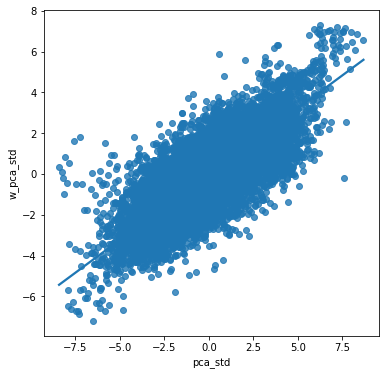

In [ ]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x='pca_std', y='w_pca_std', data=gdf19, ci=None
);

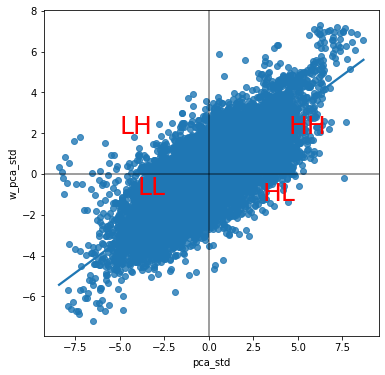

In [ ]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot('pca_std', y='w_pca_std', data=gdf19, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(4.5, 2, "HH", fontsize=25, c='r')
plt.text(3, -1.3, "HL", fontsize=25, c='r')
plt.text(-5, 2, "LH", fontsize=25, c='r')
plt.text(-4, -1.0, "LL", fontsize=25, c='r')
# Display
plt.show()

In [ ]:
lisa = esda.moran.Moran_Local(gdf19['pca_score'], w)

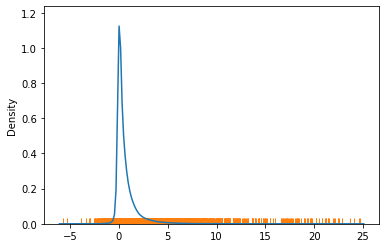

In [ ]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

#### Graphing LISA statisitics

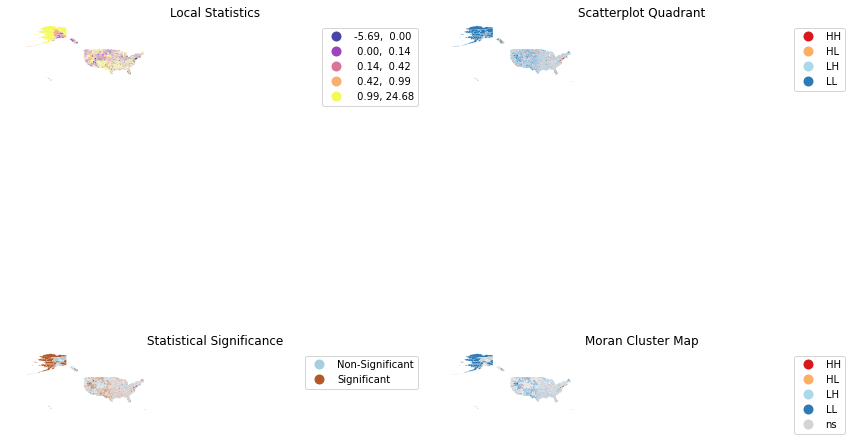

In [ ]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
            # Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
gdf19.assign(
    Is=lisa.Is
# Plot choropleth of local statistics
).plot(
    column='Is', 
    cmap='plasma', 
    scheme='quantiles',
    k=5, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

                    # Subplot 2 #
                # Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, gdf19, p=1, ax=ax);

                    # Subplot 3 #
                # Significance map
# Grab third axis of local statistics
ax = axs[2]
# 
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05), # Assign 1 if significant, 0 otherwise
    index=gdf19.index           # Use the index in the original data
# Recode 1 to "Significant and 0 to "Non-significant"
).map({1: 'Significant', 0: 'Non-Significant'})
# Assign labels to `db` on the fly
gdf19.assign(
    cl=labels
# Plot choropleth of (non-)significant areas
).plot(
    column='cl', 
    categorical=True,
    k=2,
    cmap='Paired',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

                       
                    # Subplot 4 #
                    # Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, gdf19, p=0.05, ax=ax);

                    # Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            'Local Statistics', 
            'Scatterplot Quadrant', 
            'Statistical Significance', 
            'Moran Cluster Map'
        ][i], y=0
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

#### Appending to Data Frame

In [ ]:
lisa.q[:10]

array([4, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
counts = pd.value_counts(lisa.q)
counts

1    31420
3    27482
4     6903
2     6399
dtype: int64

In [ ]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

43.27045593041937

In [ ]:
# Assign pseudo P-values to `gdf19`
gdf19['p-sim'] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
gdf19['sig'] = sig
# Print top of the table to inspect
gdf19[['sig','p-sim']].head()

,sig,p-sim
0,0,0.435
1,1,0.022
2,0,0.125
3,1,0.018
4,1,0.009


In [ ]:
# Pick as part of a quadrant only significant polygons, 
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: 'Non-Significant', 1:'HH', 2: 'LH', 3:'LL', 4: 'HL'
}
# Create column in `db` with labels for each polygon
gdf19['labels'] = pd.Series(
    # First initialise a Series using values and `db` index
    spots, index=gdf19.index
# Then map each value to corresponding label based 
# on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
gdf19['labels'].head()

0    Non-Significant
1                 LL
2    Non-Significant
3                 LL
4                 LL
Name: labels, dtype: object

In [ ]:
gdf19['labels'].value_counts()

Non-Significant    40961
HH                 15054
LL                 14502
HL                   944
LH                   743
Name: labels, dtype: int64

In [ ]:
dummy=pd.get_dummies(gdf19['labels'])
gdf19['HH']=dummy['HH']
gdf19['HL']=dummy['HL']
gdf19['LH']=dummy['LH']
gdf19['LL']=dummy['LL']

## Lasso Test for Important Variables

In [ ]:
gdf19.columns

Index(['population', 'median_age', 'median_age_male', 'median_age_female',
       'percent_male', 'percent_female', 'white', 'black', 'native', 'asian',
       ...
       'w_pca_score', 'pca_std', 'w_pca_std', 'p-sim', 'sig', 'labels', 'HH',
       'HL', 'LH', 'LL'],
      dtype='object', length=101)

In [ ]:
df_reg=gdf19[['population', 'density', 'median_age', 'median_age_male',
       'median_age_female', 'percent_male', 'percent_female', 'white', 'black',
       'native', 'asian', 'pacific_islander', 'other', 'mixed',
       'white_nonhispanic', 'black_nonhispanic', 'native_nonhispanic',
       'asian_nonhispanic', 'pacific_islander_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic', 'hispanic',
       'percent_noncitizen', 'born_in_state', 'born_in_other_state',
       'foreign_born', 'spanish_no_english', 'no_english', 'work_from_home',
       'average_commute', 'under_18', 'over_18', 'highschool_or_less',
       'no_bachelor_degree', 'bachelor_degree_only', 'advanced_degree',
       'percent_poverty', 'percent_disabled', 'less_than_10k', '10k_15k',
       '15k_20k', '20k_25k', '25k_30k', '30k_35k', '35k_40k', '40k_45k',
       '45k_50k', '50k_60k', '60k_75k', '75k_100k', '100k_125k', '125k_150k',
       '150k_200k', 'more_than_200k', 'percentage_food_stamps',
       'percentage_employed', 'percentage_unemployed',
       'civilian_labor_force_percentage', 'percentage_in_military',
       'percentage_outside_labor_force', 'management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions', 'occupied', 'vacant',
       'owner_occupied', 'rented', 'median_household_income',
       'home_value_low_quartile', 'home_value_median',
       'home_value_hi_quartile', 'median_rent', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON','geometry', 'pca_score', 'cluster_name', 'tract_type',
       'std_group', 'cscore_calculator','HH','HL', 'LH', 'LL']]

In [ ]:
df_reg['log_density']=np.log(df_reg['density'])
df_reg['r_disc']=df_reg['black_nonhispanic']+df_reg['hispanic']+df_reg['native_nonhispanic']
df_reg['log_hhi']=np.log(df_reg.median_household_income)
df_reg['log_rent']=np.log(df_reg.median_rent)
df_reg['log_home_val']=np.log(df_reg.home_value_median)

In [ ]:
df_reg.loc[df_reg.log_density>df_reg.log_density.mean()]
len(df_reg)

72204

In [ ]:
data=df_reg[['log_density','r_disc','under_18','percent_poverty','civilian_labor_force_percentage',
             'log_hhi','log_rent','vacant','HH','HL', 'LH', 'LL']]
Y=df_reg.pca_score
lm=sm.OLS(Y,sm.add_constant(data)).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              pca_score   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                 1.254e+04
Date:                Sun, 21 Aug 2022   Prob (F-statistic):               0.00
Time:                        04:16:10   Log-Likelihood:                -92202.
No. Observations:               72204   AIC:                         1.844e+05
Df Residuals:                   72191   BIC:                         1.845e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [ ]:
X = df_reg[['log_density', 'median_age', 'median_age_male',
       'median_age_female', 'percent_male','r_disc',
       'asian_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic',
       'percent_noncitizen', 'born_in_other_state',
       'foreign_born', 'no_english', 'work_from_home',
       'average_commute', 'under_18', 'highschool_or_less',
       'no_bachelor_degree', 'bachelor_degree_only',
       'percent_poverty', 'percent_disabled', 'less_than_10k', '10k_15k',
       '15k_20k', '20k_25k', '25k_30k', '30k_35k', '35k_40k', '40k_45k',
       '45k_50k', '50k_60k', '60k_75k', '75k_100k', '100k_125k', '125k_150k',
       '150k_200k',
       'percentage_employed', 'percentage_unemployed',
       'civilian_labor_force_percentage',
       'management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions', 'vacant',
       'owner_occupied', 'rented', 'log_hhi',
       'log_home_val','log_rent']].values
y = df_reg['pca_score'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

(50542, 50)
(21662, 50)


log_density,median_age_male, percent_male,

In [ ]:
X_train=np.around(X_train).astype('int32')
X_test=np.around(X_test).astype('int32')
y_train=np.around(y_train).astype('int32')
y_test=np.around(y_test).astype('int32')

In [ ]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(np.around(X_train), np.around(y_train)) 
pred_train_lasso= model_lasso.predict(np.around(X_train))
print(np.sqrt(mean_squared_error(np.around(y_train),pred_train_lasso)))
print(r2_score(np.around(y_train), pred_train_lasso))

pred_test_lasso= model_lasso.predict(np.around(X_test))
print(np.sqrt(mean_squared_error(np.around(y_test),pred_test_lasso))) 
print(r2_score(np.around(y_test), pred_test_lasso))

1.0768037762530935
0.5142169287849301
1.0955846508077698
0.5073268473367045


In [ ]:
coef_df=pd.DataFrame(data={'var_name':['log_density', 'median_age', 'median_age_male',
       'median_age_female', 'percent_male','r_disc',
       'asian_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic',
       'percent_noncitizen', 'born_in_other_state',
       'foreign_born', 'no_english', 'work_from_home',
       'average_commute', 'under_18', 'highschool_or_less',
       'no_bachelor_degree', 'bachelor_degree_only',
       'percent_poverty', 'percent_disabled', 'less_than_10k', '10k_15k',
       '15k_20k', '20k_25k', '25k_30k', '30k_35k', '35k_40k', '40k_45k',
       '45k_50k', '50k_60k', '60k_75k', '75k_100k', '100k_125k', '125k_150k',
       '150k_200k',
       'percentage_employed', 'percentage_unemployed',
       'civilian_labor_force_percentage',
       'management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions', 'vacant',
       'owner_occupied', 'rented', 'log_hhi',
       'log_home_val','log_rent']
    ,'coef':list(model_lasso.coef_)})

In [ ]:
rem_coeff=coef_df.loc[np.abs(coef_df.coef)>=.00000001]
list(rem_coeff.var_name)

['log_density',
 'median_age_male',
 'median_age_female',
 'r_disc',
 'born_in_other_state',
 'average_commute',
 'no_bachelor_degree',
 'percentage_employed',
 'management_business_science_art',
 'service_professions',
 'production_transportation_professions',
 'owner_occupied',
 'rented',
 'log_hhi',
 'log_home_val',
 'log_rent']

In [ ]:
std_df=pd.DataFrame(data={'standard_dev':df_reg.std()}).reset_index().rename(columns={'index':'var_name'})
rel_coeff=rem_coeff.merge(std_df, on='var_name')
rel_coeff['rel_value']=np.abs(rel_coeff.coef/rel_coeff.standard_dev)
rel_coeff=rel_coeff.sort_values('rel_value',ascending=False)
rel_coeff=rel_coeff.loc[(rel_coeff.rel_value>.1)&(rel_coeff.var_name!='LL')&(rel_coeff.var_name!='HH')]
rel_coeff

,var_name,coef,standard_dev,rel_value
7,percentage_employed,0.471759,0.105480,4.472478
4,born_in_other_state,0.287250,0.159151,1.804893
11,owner_occupied,0.344046,0.218604,1.573830
13,log_hhi,0.716445,0.474555,1.509720
3,r_disc,-0.429890,0.289045,1.487276
15,log_rent,0.260771,0.399984,0.651954
9,service_professions,-0.125970,0.213295,0.590592
6,no_bachelor_degree,-0.066593,0.149040,0.446812
14,log_home_val,0.304893,0.740526,0.411725
12,rented,-0.078452,0.205435,0.381885


In order, places that are left out tend to have:

*   high unemployment
*   lower rates of people born out of state
*   lower levels of owner-occupied places
*   lower levels of household income
*   higher levels of black, indegenous, and hispanic people
*   lower rents
*   higher rates of people in service professions
*   higher rates of people without bachelor degrees
*   lower home values
*   higher level of renters
*   higher rates of people in management business science and art
*   lower density tracts

We can now filter out HH (They are doing fine), and HL (Weirdly doing fine). This leaves LL, LH, and non-significant (doesn't fit under the other exclusionary conditions).

Then filter to higher than average percent poverty (for whole country), higher than average r_disc (black, hispanic, native), and lower than average log_hhi.

Exclude rural areas and order by density to get the easiest place to put in broadband.

This list shows most excluded areas.

In [ ]:
df_reg.loc[
           (df_reg.HH!=1)&
           (df_reg.HL!=1)&
           (df_reg.percent_poverty>df_reg.percent_poverty.mean())&
           (df_reg.r_disc>df_reg.r_disc.mean())&
           (df_reg.log_hhi<df_reg.log_hhi.mean())&
           (df_reg.pca_score<0)&
           (df_reg.tract_type!='rural')
].sort_values('density',ascending=False)

,population,density,median_age,median_age_male,median_age_female,percent_male,percent_female,white,black,native,...,cscore_calculator,HH,HL,LH,LL,log_density,r_disc,log_hhi,log_rent,log_home_val
44633,5411.0,0.069112,30.0,27.2,34.1,0.484199,0.515801,0.143781,0.168546,0.007762,...,-0.0,0,0,0,0,-2.672024,0.973572,10.397940,7.118016,12.534297
44600,4320.0,0.063649,42.4,41.3,43.3,0.464352,0.535648,0.168981,0.343750,0.002083,...,-4320.0,0,0,0,0,-2.754368,0.914815,10.521507,7.100852,12.491252
11417,3674.0,0.059959,54.4,52.9,57.4,0.559336,0.440664,0.234077,0.152150,0.075395,...,-11022.0,0,0,0,0,-2.814091,0.385139,9.688374,6.265301,13.922120
45696,3533.0,0.059268,26.3,26.1,26.5,0.371073,0.628927,0.101613,0.572884,0.000000,...,-0.0,0,0,0,0,-2.825693,0.969431,9.807362,6.204558,13.523017
46961,10255.0,0.058361,38.0,38.2,36.7,0.467089,0.532911,0.454608,0.213652,0.000000,...,-0.0,0,0,0,0,-2.841104,0.564408,10.923706,7.327123,13.339086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21266,7929.0,0.000025,36.5,37.3,36.0,0.430067,0.569933,0.671081,0.248707,0.014251,...,-15858.0,0,0,0,1,-10.604599,0.335351,10.447409,6.568078,11.630709
20353,4968.0,0.000025,41.1,33.2,44.7,0.484501,0.515499,0.443841,0.546296,0.000000,...,-4968.0,0,0,0,1,-10.606083,0.549316,10.598084,6.359574,11.848683
9935,3812.0,0.000025,50.0,49.0,51.4,0.551154,0.448846,0.844176,0.034627,0.000000,...,-0.0,0,0,0,0,-10.606700,0.493704,10.171604,6.845880,11.512925
2678,3980.0,0.000025,47.3,44.5,49.2,0.483920,0.516080,0.597739,0.392965,0.003266,...,-0.0,0,0,0,1,-10.606849,0.396231,10.720179,6.654153,11.538593


## save out data

In [ ]:
df_reg.to_csv('processed data/acs_equity.csv')